# App with a Router
* Goal: replicate the previous exercise, but this time using a conditional edge as a router to decide between two nodes.

## Setup

#### After you download the code from the github repository in your computer
In terminal:
* cd project_name
* pyenv local 3.11.4
* poetry install
* poetry shell

#### To open the notebook with Jupyter Notebooks
In terminal:
* jupyter lab

Go to the folder of notebooks and open the right notebook.

#### To see the code in Virtual Studio Code or your editor of choice.
* open Virtual Studio Code or your editor of choice.
* open the project-folder
* open the 005-graph-with-router.py file

## Create your .env file
* In the github repo we have included a file named .env.example
* Rename that file to .env file and here is where you will add your confidential api keys. Remember to include:
* OPENAI_API_KEY=your_openai_api_key
* LANGCHAIN_TRACING_V2=true
* LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
* LANGCHAIN_API_KEY=your_langchain_api_key
* LANGCHAIN_PROJECT=your_project_name

## Track operations
From now on, we can track the operations **and the cost** of this project from LangSmith:
* [smith.langchain.com](https://smith.langchain.com)

## Connect with the .env file located in the same directory of this notebook

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [1]:
#pip install python-dotenv

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai_api_key = os.environ["OPENAI_API_KEY"]

#### Install LangChain

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [3]:
#!pip install langchain

## Connect with an LLM

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [4]:
#!pip install langchain-openai

In [5]:
from langchain_openai import ChatOpenAI

chatModel35 = ChatOpenAI(model="gpt-3.5-turbo-0125")
chatModel4o = ChatOpenAI(model="gpt-4o")

## Let's start by re-using the LLM with tools we created in the previous exercise

In [6]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

chatModel4o_with_tools = chatModel4o.bind_tools([multiply])

## Building an app (called "graph" in langgraph) that decides if it respondes the user question by using a chatbot or a tool

* Here you have a graphic representation of the app we will build:

![Simple graph](graph003.png)

## Define the State schema of the graph
* The first thing you do when you define a graph is define the State of the graph. 
* The State schema defines the format of the input for all nodes and edges in the graph.
* The schema of the State can be either a TypedDict or a Pydantic model.

* For this example, we will use the same MessagesState we used in the previous exercise:

In [7]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

## Define the Nodes of the graph
* The Nodes of a graph are defined as python functions.
* The first argument of a Node function is the state. Because of that, in this exercise each node can access the key `messages`, with `state['messages']`.
* In this example, we will start with the node we created in the previous exercise:

In [8]:
from langgraph.graph import MessagesState

# Node
def llm_with_tool(state: MessagesState):
    return {"messages": [chatModel4o_with_tools.invoke(state["messages"])]}

## Combine Nodes and Edges to build the Graph
* First, we initialize a StateGraph with the `MessagesState` class we defined above.
* Then, we add the nodes and edges.
* **See how we are using the ToolNode LangGraph built-in component to create the tool-using node called "tools"**.
    * We use ToolNode to call the tool. 
* **See how we are adding the conditional edge with the tools_condition LangGraph built-in component as our router**.
* The `START` Node is a special node that sends user input to the graph, to indicate where to start our graph.
* The `END` Node is a special node that represents a terminal node.
* We compile our graph to perform a few basic checks on the graph structure.
* Finally, we visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

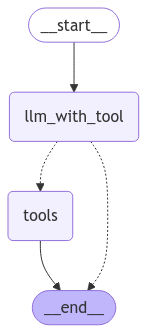

In [12]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Build graph
builder = StateGraph(MessagesState)

builder.add_node("llm_with_tool", llm_with_tool)
builder.add_node("tools", ToolNode([multiply]))

# Add the logic of the graph
builder.add_edge(START, "llm_with_tool")

builder.add_conditional_edges(
    "llm_with_tool",
    # If the input is a tool call -> tools_condition routes to tools
    # If the input is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", END)

# Compile the graph
graph = builder.compile()

# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

## Run the app
* The compiled graph implements the runnable protocol, a standard way to execute LangChain components. Because of that, we can use `invoke` as one of the standard methods to run this app.
* **With our initial input, there is no need to use the tools**.
* When `invoke` is called:
    * The graph starts execution from the `START` node.
    * It progresses through the defined node.
    * The execution continues until it reaches the `END` node.

In [10]:
from pprint import pprint
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="What was the relationship between Lem Billings and JFK?")]

messages = graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What was the relationship between Lem Billings and JFK?
================================== Ai Message ==================================

Lem Billings and John F. Kennedy (JFK) had a close and enduring friendship. They met as teenagers at the Choate School, a private preparatory school in Connecticut, and quickly became best friends. Their friendship lasted throughout JFK's life, with Billings often being considered a part of the Kennedy family.

Billings was known for his loyalty and dedication to JFK. He was a constant presence in Kennedy's life, even during his presidency, and was often involved in family gatherings and events. Despite their different backgrounds—Billings came from a wealthy family in Pittsburgh—he and JFK shared a strong bond and mutual respect. Billings was also known for his wit and charm, qualities that complemented Kennedy's personality.

Their friendship is often highlighted as a

* **With the second input, the app now uses the tool we defined**:

In [11]:
messages = [HumanMessage(content="Multiply 4 and 5")]

messages = graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 4 and 5
================================== Ai Message ==================================
Tool Calls:
  multiply (call_JBJcAWySb1tMEUaUvCtvkQcQ)
 Call ID: call_JBJcAWySb1tMEUaUvCtvkQcQ
  Args:
    a: 4
    b: 5
================================= Tool Message =================================
Name: multiply

20


* As you see, our app was able to route our inputs correctly.

![Simple graph](graph003.png)

## How to execute the code from Visual Studio Code
* In Visual Studio Code, see the file 005-graph-with-router.py
* In terminal, make sure you are in the directory of the file and run:
    * python 005-graph-with-router.py